# Item-based collaborative filtering

Here, I'm going to compute item similarities using only user interactions.

In effect, similarity is based on unknown, latent features of each user and item. These features represent qualities of users and items that make users likely or unlikely to interact with items.

## Memory-based approach

This method does not generate a model or reduce dimensions, so it does not scale well to large datasets. Similarity is computed using the Scikit Learn `cosine_similarity` function.

In [49]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
USE_SAVED_DATA = True

In [51]:
import pandas as pd
import numpy as np
import scipy.sparse as sp
from sklearn.preprocessing import LabelEncoder
from matspy import spy

from pipeliner.recommendations.transformer import (
    SimilarityTransformer,
    UserItemMatrixTransformer,
)
from pipeliner.recommendations.recommender import SimilarityRecommender

pd.options.display.float_format = "{:,.2f}".format

In [52]:
data_types = {"user_id": str, "item_id": str, "rating": np.float64}
user_item_ratings = pd.read_csv(
    "./data/usable_user_item_ratings_prepared.csv.gz",
    compression="gzip",
    dtype=data_types,
)

# confirm that each user/item pair is unique
assert user_item_ratings.groupby(["user_id", "item_id"]).size().max() == 1

print(user_item_ratings.shape)
user_item_ratings.head(3)

(1522154, 3)


,user_id,item_id,rating
0,U000003,I00037925,0.61
1,U000003,I00189384,0.61
2,U000003,I00256366,0.61


In [53]:
# create a smaller dataset for the memory-based recommender
MAX_INTERACTIONS_PER_USER = 500
SAMPLE_SIZE = 50000

user_item_ratings_sample = (
    (
        user_item_ratings.groupby("user_id")
        .head(MAX_INTERACTIONS_PER_USER)
        .reset_index(drop=True)
    )
    .head(SAMPLE_SIZE)
    .reset_index(drop=True)
)

print(user_item_ratings_sample.shape)
user_item_ratings_sample.head(3)

(50000, 3)


,user_id,item_id,rating
0,U000003,I00037925,0.61
1,U000003,I00189384,0.61
2,U000003,I00256366,0.61


In [54]:
# encode the user and item ids
user_sample_encoder = LabelEncoder()
item_sample_encoder = LabelEncoder()

user_item_ratings_sample["user_id"] = user_sample_encoder.fit_transform(user_item_ratings_sample["user_id"])
user_item_ratings_sample["item_id"] = item_sample_encoder.fit_transform(user_item_ratings_sample["item_id"])

unique_sample_users = pd.Series(user_sample_encoder.classes_)
unique_sample_items = pd.Series(item_sample_encoder.classes_)

print(unique_sample_users.shape[0], unique_sample_items.shape[0])
user_item_ratings_sample.head(3)

1334 45021


,user_id,item_id,rating
0,0,2546,0.61
1,0,10854,0.61
2,0,13742,0.61


In [55]:

user_item_matrix_transformer = UserItemMatrixTransformer()

if USE_SAVED_DATA is False:
        # create the user/item matrix
    user_item_matrix_sample = user_item_matrix_transformer.transform(
        user_item_ratings_sample.to_numpy(),
    )
else:
    user_item_matrix_sample = sp.load_npz("data/03-collaborative-filtering/user_item_matrix_sample.npz")

# check ratings from matrix are correct
users = user_item_ratings_sample["user_id"].to_numpy().astype(int)
items = user_item_ratings_sample["item_id"].to_numpy().astype(int)
ratings = user_item_ratings_sample["rating"].to_numpy().astype(np.float32)
for user, item, rating in zip(users, items, ratings):
    assert user_item_matrix_sample[user, item] == rating

print(user_item_matrix_sample.shape)

(1334, 45021)


In [56]:
similarity_matrix_transformer = SimilarityTransformer()
if USE_SAVED_DATA is False:
    user_similarity_matrix_sample = similarity_matrix_transformer.transform(
        user_item_matrix_sample
    )
    item_similarity_matrix_sample = similarity_matrix_transformer.transform(
        user_item_matrix_sample.T
    )
else:
    user_similarity_matrix_sample = sp.load_npz("data/03-collaborative-filtering/user_similarity_matrix_sample.npz")
    item_similarity_matrix_sample = sp.load_npz("data/03-collaborative-filtering/item_similarity_matrix_sample.npz")
    
user_similarity_matrix_sample.shape, item_similarity_matrix_sample.shape

((1334, 1334), (45021, 45021))

In [57]:
if USE_SAVED_DATA is False:
    sp.save_npz(
        "data/03-collaborative-filtering/user_item_matrix_sample.npz",
        user_item_matrix_sample,
        compressed=True,
    )
    sp.save_npz(
        "data/03-collaborative-filtering/user_similarity_matrix_sample.npz", 
        user_similarity_matrix_sample, 
        compressed=True
    )
    sp.save_npz(
        "data/03-collaborative-filtering/item_similarity_matrix_sample.npz", 
        item_similarity_matrix_sample, 
        compressed=True
    )

Generate item recomendation using sample dataset

In [58]:
item_idx = item_sample_encoder.transform(["I00037925"])

similarity_recommender = SimilarityRecommender(10)
similarity_recommender.fit(item_similarity_matrix_sample)
recommendatons = similarity_recommender.predict(item_idx)

results = [
    item_sample_encoder.inverse_transform(item).tolist() for item in recommendatons
][0]

probabilities = similarity_recommender.predict_proba(item_idx).toarray()[0]

results, probabilities

(['I00189384',
  'I00267268',
  'I00298191',
  'I00316072',
  'I00318138',
  'I00590125',
  'I00758300',
  'I00846427',
  'I00891970',
  'I00944931'],
 array([0., 0., 0., ..., 0., 0., 0.], shape=(45021,)))

Now try with the full dataset

In [59]:
# encode the user and item ids
user_full_encoder = LabelEncoder()
item_full_encoder = LabelEncoder()

user_item_ratings_full = user_item_ratings.copy()

user_item_ratings_full["user_id"] = user_full_encoder.fit_transform(
    user_item_ratings_full["user_id"]
)
user_item_ratings_full["item_id"] = item_full_encoder.fit_transform(
    user_item_ratings_full["item_id"]
)

unique_full_users = pd.Series(user_full_encoder.classes_)
unique_full_items = pd.Series(item_full_encoder.classes_)

print(unique_full_users.shape[0], unique_full_items.shape[0])
user_item_ratings_full.head(3)

37740 777584


,user_id,item_id,rating
0,0,21365,0.61
1,0,109512,0.61
2,0,145357,0.61


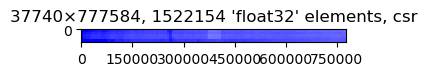

In [60]:
user_item_matrix_full = user_item_matrix_transformer.transform(
    user_item_ratings_full.to_numpy(),
)

spy(user_item_matrix_full)

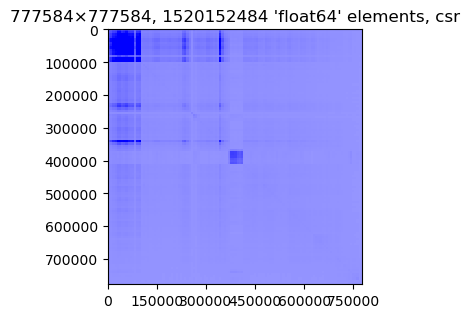

In [61]:
item_similarity_matrix_full = similarity_matrix_transformer.transform(
    user_item_matrix_full.T
)

spy(item_similarity_matrix_full)

In [62]:
similarity_recommender_full = SimilarityRecommender(10)
similarity_recommender_full.fit(item_similarity_matrix_full)
recommendatons = similarity_recommender_full.predict(item_idx)

results = [
    item_full_encoder.inverse_transform(item).tolist() for item in recommendatons
][0]

results

['I00162606', 'I00003183', 'I00019948', 'I00976647', 'I00497803']